# Optimal control

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

import scipy as sp

import sys, os
sys.path.append('..')
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import scipy as sp
from scipy.sparse import coo_matrix

In [3]:
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 22.0.3. Latest version is 22.1.0.

Visit ]8;id=542390;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [4]:
from slab import  AttrDict
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\..\\..\\experiments\\qramLL_4QR2\\' + config_file
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs = np.array(yaml_cfg.device.qubit.f_ge) * 1e-3
ef_freqs = np.array(yaml_cfg.device.qubit.f_ef) * 1e-3
gs = np.array(yaml_cfg.device.qubit.gs) * 1e-3
# gs = 0*np.array(yaml_cfg.device.qubit.gs) * 1e-3

ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) * 1e-3 # MHz
EJs = None
ECs = None
alphas = ef_freqs - qubit_freqs

print(qubit_freqs)
print(alphas)
print(yaml_cfg.device.qubit.gs)


 c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py: 12

Could not load InstrumentManagerWindow
Could not import QickSoc: No module named 'pynq'
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver
[4.13020013 3.45636635 4.78514053 4.39830474]
[-0.2254654  -0.10036622 -0.18964499 -0.17263621]
[54.98834995, 55.21613685, 44.21773961, 7.06638874, 2.63846655, 6.19737439]


In [5]:
# cutoffs = [3, 3, 3, 3]
cutoffs = [2, 3, 2, 2]
isCavity = [False, False, False, False]

dispersive = False

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=dispersive,
    ZZs=ZZs_4q,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print(f"using {'dispsersive' if dispersive else 'full'} Hamiltonian")

qubit freqs (GHz) 4.1302001349834745 3.456366348279435 4.785140528992779 4.398304741018806
alphas (GHz) -0.22546539508285335 -0.10036622050866129 -0.18964499334802465 -0.1726362120064433
using full Hamiltonian


Optimizer parameters

In [130]:
# All units in GHz/ns
unitary_cost = True # use unitary cost function or state transfer cost function

dims = qram.cutoffs
krylov_dims = 30 # Sparse representation dimensions

max_drive_q = 0.070 # Max drive for qubit pulses (linear GHz)
gate_duration = 150 # [ns]

# sinc cutoff defines I, Q frequency
# should be << wq since drive amplitude is just modulating the rotating terms
sinc_cutoffs = np.array([200, 200, 200, 200])*2*np.pi*1e-3 # [GHz]
# ncycles = np.ceil(sinc_cutoffs*gate_duration/2/np.pi).astype(int) # per gate duration for frequency cutoff for drive
ncycles = np.ceil(sinc_cutoffs*gate_duration/2/np.pi).astype(int)
num_opt_vars = 2*ncycles
num_segments = 10*max(ncycles)

num_segments = min((num_segments, int(gate_duration / 0.1565))) # hardware maximum: 1 sample every 0.1565 ns
print('num cycles', ncycles)
print('num segments', num_segments)
print('time step', gate_duration/num_segments)
print('num segments per cycle of drive (determines sampling of drive)', num_segments/ncycles)
print('sinc_cutoffs (MHz)', sinc_cutoffs/2/np.pi * 1e3)


# max_drive_sb = 0.100 # Max drive for sb pulses
# num_opt_vars_sb = 32
# num_segments_sb = 1000

# sinc_cutoff_sb = 2*np.pi*10/gate_duration # [GHz]
# print('sinc_cutoff_sb', sinc_cutoff_sb/2/np.pi)
# print(f'Need {4/gate_duration} < sinc cutoff sb < {num_segments_sb/gate_duration}')

# freq_sb = 2*qubit_freqs[1] + alphas[1] - qubit_freqs
# freq_sb_rot = freq_sb - qubit_freqs # sideband frequency in the interaction picture
# print(freq_sb)

num cycles [30 30 30 30]
num segments 300
time step 0.5
num segments per cycle of drive (determines sampling of drive) [10. 10. 10. 10.]
sinc_cutoffs (MHz) [200. 200. 200. 200.]


Define qctrl hamiltonian and drive terms

<!-- Applies drive term $\sum_q (\gamma_q(t)e^{i\omega_qt}a_q + h.c.) + \sum_q (\epsilon_q(t)e^{i\omega_{SB}t}a_q + h.c.)$ -->
In the rotating frame: applies drive term $\sum_q (\gamma_q(t)a_q + h.c.)$

$\gamma_j(t), \epsilon_j(t)=I_j(t)\sin(\omega_j t)+Q_j(t)\cos(\omega_j t)$

<!-- $\gamma_q$ will be filtered to be near the $\omega_{01}$ of qubit $q$, $\epsilon_q$ will be filtered to be near the sideband pulse for $|eg\rangle\to|gf\rangle$ with the first qubit being qubit $q$. -->

<!-- Since we are in the rotating frame of the qubit frequencies, apply a sinc cutoff for the qubit pulses and a gaussian bandlimit for the sideband pulses. -->
Everything done relative to frame given by frame_freq!

In [131]:
def unit_gauss(t, sigma, sigma_n=4):
    t_max = sigma_n/2*sigma # point of max in gaussian
    return np.exp(-(t-t_max)**2/2/sigma**2)

def setup_graph(graph, frame_freq=None, initial_values=None, unitary_cost=True):
    output_node_names = []

    # initial envelopes

    # # enforces endpoints of I, Q to be 0
    # envelope_q = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_q))
    # # envelope_sb = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_sb))

    envelope_Is = [None]*4
    envelope_Qs = [None]*4
    sinc_kernels = [None]*4
    for q in range(qram.nqubits):
        amp = 0.1
        if q == 1: amp = 1
        if sinc_cutoffs[q] == 0: continue
        envelope_Is[q] = amp*unit_gauss(t=np.linspace(0, 4, num_opt_vars[q]), sigma=1)
        envelope_Qs[q] = amp*unit_gauss(t=np.linspace(0, 4, num_opt_vars[q]), sigma=1)
        sinc_kernels[q] = graph.sinc_convolution_kernel(sinc_cutoffs[q])
    envelopes = (envelope_Is, envelope_Qs)

    # Bandlimit the qubit pulses
    # sinc_kernel_sb = graph.sinc_convolution_kernel(sinc_cutoff_sb)

    # Set up optimizer variables for [I, Q] component of drive

    drives = []
    t = graph.identity_stf() # f(t) = t

    # Single qubit drives
    for q in range(qram.nqubits):
        # if q != 1: continue
        if sinc_cutoffs[q] == 0: continue
        drive_signals = [] # I, Q
        for j in range(2): # I, Q
            if initial_values is None: init_val = None
            else: init_val = initial_values[f"drive_vars_{'I' if j==0 else 'Q'}_{q}"]
            drive_vars = graph.optimization_variable(
                count=num_opt_vars[q],
                lower_bound=-max_drive_q,
                upper_bound=max_drive_q,
                initial_values=init_val,
                name=f"drive_vars_{'I' if j==0 else 'Q'}_{q}",
            )
            output_node_names.append(drive_vars.name)
            drive_vars = drive_vars * envelopes[j][q]
            # drive_vars = drive_vars * 0*envelopes[j][q]

            # Build the pulse signal with segments based on the optimizer variables
            drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
            drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernels[q])

            # Discretize the filtered drive into the desired number of segments
            drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments)
            drive_signal.name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
            output_node_names.append(drive_signal.name)
            drive_signals.append(drive_signal)

        # hermitian_part(A) returns 1/2 (A + A^(dag)), drive is a(I-iQ) + adag(I+iQ)
        # wq_exp = graph.exp(1j*2*np.pi*(qubit_freqs[q]-frame_freq)*t)
        # wq_exp_stf = graph.discretize_stf(stf=wq_exp, duration=gate_duration, segment_count=num_segments_q)
        if unitary_cost:
            drives.append(
                graph.hermitian_part(
                    graph.pwc_operator(
                        signal=(drive_signals[0]-1j*drive_signals[1])*2*np.pi, # wq_exp_stf,
                        operator=qram.a_ops[q].data.todense()
                        )
                    )
                ) # drive on qubit q
        else:
            drives.append(
            graph.sparse_pwc_hermitian_part(
                graph.sparse_pwc_operator(
                    signal=(drive_signals[0]-1j*drive_signals[1])*2*np.pi, # wq_exp_stf,
                    operator=coo_matrix(qram.a_ops[q].data)
                    )
                )
            ) # drive on qubit q

    # # 2Q sideband drives (eg <-> gf)
    # # loop over qubits q for driving between qubit q and qubit 1
    # for q in range(qram.nqubits):
    #     if q == 1: continue
    #     drive_signals = [] # I, Q
    #     for j in range(2): # I, Q
    #         drive_vars = graph.optimization_variable(
    #             count=num_opt_vars_sb,
    #             lower_bound=-max_drive_sb,
    #             upper_bound=max_drive_sb,
    #             name='drive_vars_sb',
    #         )
    #         output_node_names.append(drive_vars.name)
    #         drive_vars = drive_vars * envelope_sb

    #         # Build the pulse signal with segments based on the optimizer variables
    #         drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
    #         drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernel_sb)

    #         # Discretize the filtered drive into the desired number of segments
    #         drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments_sb)
    #         drive_signal.name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
    #         output_node_names.append(drive_signal.name)
    #         drive_signals.append(drive_signal)

    #     # hermitian_part(A) returns 1/2 (A + A^(dag))
    #     w_sb_exp = graph.exp(1j*2*np.pi*(freq_sb[q]-frame_freq)*t)
    #     w_sb_exp_stf = graph.discretize_stf(stf=w_sb_exp, duration=gate_duration, segment_count=num_segments_sb)
    #     drives.append(
    #         graph.sparse_pwc_hermitian_part(
    #             graph.sparse_pwc_operator(
    #                 signal=(-1j*drive_signals[0]+drive_signals[1]) * w_sb_exp_stf,
    #                 operator=coo_matrix(qram.a_ops[1].data)
    #                 )
    #             )
    #         ) # drive on qubit 1

    if unitary_cost:
        H_drive = graph.pwc_sum(drives)
        H_sys = graph.pwc_operator(
            signal=graph.pwc_signal(values=np.array([1]), duration=gate_duration),
            operator=qram.H_rot_qubits(qubit_frame_freqs=qram.qubit_freqs).data.todense(),
        )

        # Construct the total Hamiltonian
        H_tot = graph.pwc_sum([H_sys, H_drive])

    else:
        H_drive = graph.sparse_pwc_sum(drives)
        sparse_H_sys = graph.sparse_pwc_operator(
            signal=graph.pwc_signal(values=np.array([1]), duration=gate_duration),
            operator=coo_matrix(qram.H_rot_qubits(qubit_frame_freqs=qram.qubit_freqs).data),
            # operator=coo_matrix(qram.H_rot(wd=qram.get_base_wd('gggg', 'gegg')).data),
        )

        # Construct the total Hamiltonian
        H_tot = graph.sparse_pwc_sum([sparse_H_sys, H_drive])

    return H_tot, output_node_names

esys_rot_wd = qram.H_rot(wd=qram.get_base_wd('gggg', 'gegg')).eigenstates()
evals, evecs = esys_rot_wd
def unrotate(graph, result, t): # result should be a np array
    # return result
    result_rot = 0*result
    evals, evecs = esys_rot_wd
    for eval, evec in zip(evals, evecs):
        # |a> = sum_i(|biXbi|a>), a.overlap(b) = <a|b>
        evec_flat = evec.full().flatten()
        overlap = graph.sum(np.conj(evec_flat) * result)
        # print(eval)
        result_rot += np.exp(1j*eval*t) * overlap * evec_flat
    return result_rot

Cost function

In [132]:
"""
Optimize such that each psi0s[i] -> targets[i] (these are all qutip states)
Sample sample_state at times sample_times (sample_state should be a qutip state)
"""
def setup_cost_state_transfer(graph, psi0s, psi0_names, targets, sparse_H_tot, output_node_names, sample_states, sample_names, sample_times):
    evol_states = [] # time evolution starting from each psi0
    for psi0, psi0_name in zip(psi0s, psi0_names):
        evol_states.append(
            graph.state_evolution_pwc(
                initial_state=psi0.full().flatten(),
                hamiltonian=sparse_H_tot,
                krylov_subspace_dimension=krylov_dims,
                # evaluated at end of gate
                sample_times=sample_times, # times at which to sample the trial state
                name=psi0_name,
        ))
        output_node_names.append(psi0_name)

    # for sample_state, sample_name in zip(sample_states, sample_names):
    #     sample_state = graph.state_evolution_pwc(
    #             initial_state=sample_state.full().flatten(),
    #             hamiltonian=sparse_H_tot,
    #             krylov_subspace_dimension=krylov_dims,
    #             sample_times=sample_times, # times at which to sample the trial state
    #             name=sample_name,
    #             ) # [times, states]
    #     output_node_names.append(sample_name)

    target_states = [psif.full().flatten() for psif in targets]
    assert len(targets) == len(psi0s)
    assert len(target_states) == len(evol_states)

    infidelity = graph.abs(
        graph.sum([1 - 
            graph.abs(graph.sum(
                graph.conjugate(target) * evol_states[i][-1]))**2 # compare to the evol state at end of evolution
                # graph.conjugate(target) * unrotate(graph, evol_states[i][-1], t=gate_duration)))**2 # compare to the evol state at end of evolution
            for i, target in enumerate(target_states)
            ]) / len(target_states),
        name='infidelity'
    )

    # possibly need to add cost for populating top/truncated level of transmons if allowing drive strengths > anharmonicity

    cost = infidelity
    cost.name = 'cost'
    output_node_names.append('cost')
    return output_node_names

In [133]:
def setup_cost_unitary(graph, target_operator, H_tot, output_node_names, sample_times):#, sample_states, sample_names, sample_times):
        
    target = graph.target(
        target_operator
    )
    
    # you could include noise operators here - e.g. add some crosstalk coefficient from drive on qi to drive on qj
    infidelity = graph.infidelity_pwc(
        hamiltonian=H_tot,
        target=target,
#         name='infidelity',
    )
    
    unitary_operators = graph.time_evolution_operators_pwc(
        hamiltonian=H_tot,
        sample_times=sample_times,
        name="unitaries"
    )
    output_node_names.append("unitaries")

    cost = infidelity
    cost.name = 'cost'
    output_node_names.append('cost')
    return output_node_names

### Full protocol

Set up cost functions. Want to maximize these transitions:

- $|eggg\rangle \to |ggeg\rangle$
- $|eegg\rangle \to |gege\rangle$
- $|gggg\rangle \to |gggg\rangle$
- $|gegg\rangle \to |gegg\rangle$

### Pi pulse

Set up cost functions. Want to maximize these transitions on Q1:

- $|0\rangle \to |1\rangle$
- $|1\rangle \to |0\rangle$
- $|0+1\rangle \to |0+1\rangle$
- $|0+i1\rangle \to |0-i1\rangle$

Do this for the 4 possibilities of the states of the 3 qubits other than Q1, where up to 1 qubit is in excited:

$|0000\rangle$, $|1000\rangle$, $|0010\rangle$, $|0001\rangle$


State transfer costs

In [134]:
psi0s = []
psi0names = []
psifs = []
psifnames = []
# for each of the 4 possible coupled ground states, need to implement the X gate unitary: 0->1, 1->0, 0+1->0+1, 0+i1->0-i1
# we also need to make sure each of the non Q1 qubits does not acquire a phase

Upsi0names = ['g', 'e', '(g+e)', '(g+ie)']
Xpsifnames = ['e', 'g', '(g+e)', '(g-ie)']
Upsi0s = [None]*4
Xpsifs = [None]*4
for q in range(4):
    gstate = qt.basis(cutoffs[q], 0)
    estate = qt.basis(cutoffs[q], 1)
    Upsi0s[q] = [gstate, estate, (gstate + estate).unit(), (gstate + 1j*estate).unit()]
    Xpsifs[q] = [estate, gstate, (gstate + estate).unit(), (gstate - 1j*estate).unit()]
gggg = 'gggg'

X = qt.qip.operations.rx(np.pi)
for q in range(4): # go from gxgg, ixgg, gxig, gxgi
    tensor_state = [qt.basis(cutoffs[q], 0) for q in range(4)] # gggg
    for Ipsi0, Ipsi0name in zip(Upsi0s[q], Upsi0names):
        gistatename = gggg

        if q != 1:
            tensor_state[q] = Ipsi0
            gistatename = gggg[:q] + Ipsi0name + gggg[q+1:]

        # X operation on Q = 1
        for Xpsi0, Xpsif, Xpsi0name, Xpsifname in zip(Upsi0s[1], Xpsifs[1], Upsi0names, Xpsifnames):
            q1_name_ind = 1 if (q > 0 or len(Ipsi0name) == 1) else len(Ipsi0name)
            psi0name = gistatename[:q1_name_ind] + Xpsi0name + gistatename[q1_name_ind+1:]
            psifname = gistatename[:q1_name_ind] + Xpsifname + gistatename[q1_name_ind+1:]

            if psi0name in psi0names: continue

            psi0names.append(psi0name)
            psifnames.append(psifname)

            tensor_state[1] = Xpsi0
            psi0s.append(qt.tensor(*tensor_state))

            tensor_state[1] = Xpsif
            psifs.append(qt.tensor(*tensor_state))

print(psi0names)
print(psifnames)
print(len(psi0names))

['gggg', 'gegg', 'g(g+e)gg', 'g(g+ie)gg', 'eggg', 'eegg', 'e(g+e)gg', 'e(g+ie)gg', '(g+e)ggg', '(g+e)egg', '(g+e)(g+e)gg', '(g+e)(g+ie)gg', '(g+ie)ggg', '(g+ie)egg', '(g+ie)(g+e)gg', '(g+ie)(g+ie)gg', 'ggeg', 'geeg', 'g(g+e)eg', 'g(g+ie)eg', 'gg(g+e)g', 'ge(g+e)g', 'g(g+e)(g+e)g', 'g(g+ie)(g+e)g', 'gg(g+ie)g', 'ge(g+ie)g', 'g(g+e)(g+ie)g', 'g(g+ie)(g+ie)g', 'ggge', 'gege', 'g(g+e)ge', 'g(g+ie)ge', 'ggg(g+e)', 'geg(g+e)', 'g(g+e)g(g+e)', 'g(g+ie)g(g+e)', 'ggg(g+ie)', 'geg(g+ie)', 'g(g+e)g(g+ie)', 'g(g+ie)g(g+ie)']
['gegg', 'gggg', 'g(g+e)gg', 'g(g-ie)gg', 'eegg', 'eggg', 'e(g+e)gg', 'e(g-ie)gg', '(g+e)egg', '(g+e)ggg', '(g+e)(g+e)gg', '(g+e)(g-ie)gg', '(g+ie)egg', '(g+ie)ggg', '(g+ie)(g+e)gg', '(g+ie)(g-ie)gg', 'geeg', 'ggeg', 'g(g+e)eg', 'g(g-ie)eg', 'ge(g+e)g', 'gg(g+e)g', 'g(g+e)(g+e)g', 'g(g-ie)(g+e)g', 'ge(g+ie)g', 'gg(g+ie)g', 'g(g+e)(g+ie)g', 'g(g-ie)(g+ie)g', 'gege', 'ggge', 'g(g+e)ge', 'g(g-ie)ge', 'geg(g+e)', 'ggg(g+e)', 'g(g+e)g(g+e)', 'g(g-ie)g(g+e)', 'geg(g+ie)', 'ggg(g+ie)

Unitary costs

In [135]:
# project onto subspace of Q1 with other qubits in g or single excitation gxgg, exgg, gxeg, gxge

projected_basis = []
qubit_states = [None]*4
for q in range(4):
    gstate = qt.basis(cutoffs[q], 0)
    estate = qt.basis(cutoffs[q], 1)
    qubit_states[q] = [gstate, estate]

for q in range(4):
    tensor_state = [qt.basis(cutoffs[q], 0) for q in range(4)] # gggg
    if q != 1:
        tensor_state[q] = qubit_states[q][1] # estate
    for q1_state in qubit_states[1]:
        tensor_state[1] = q1_state
        projected_basis.append(qt.tensor(*tensor_state))
computational_projector = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)
for state in projected_basis:
    computational_projector += (state * state.dag()).full()
    
# pad X unitary to full Hilbert space for Q1
X = qt.qip.operations.rx(np.pi)
X = np.array(X)
Xfull = np.pad(X, ((0,cutoffs[1]-2),(0,cutoffs[1]-2)))
for j in range(2, cutoffs[1]):
    Xfull[j, j] = 1.

target_operator = np.eye(cutoffs[0])

for q in range(1, qram.nqubits):
    target_operator = np.kron(target_operator, Xfull) if q == 1 else np.kron(target_operator, np.eye(cutoffs[q]))

print(target_operator)
print(computational_projector)

computational_target_operator = computational_projector @ target_operator @ computational_projector

[[6.123234e-17+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00-1.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 6.123234e-17+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00-1.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 6.123234e-17+0.j 0.000000e+00+0.j
  0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00-1.j 0.000000e+00+0.j
  0.000000e+00+0.j

### Run optimization

Load previous resuts as initial seed pulse

In [136]:
# Previous results
initial_values = None
# initial_values = dict()
# ctrl_result = qctrl.get_result(action_id=1765949)
# if 'drive_vars_I_1' in ctrl_result.output.keys():
#     for q in range(qram.nqubits):
#         if q != 1: continue
#         drive_signals = [] # I, Q
#         for j in range(2): # I, Q
#             name = f"drive_vars_{'I' if j==0 else 'Q'}_{q}"
#             if name in ctrl_result.output.keys():
#                 initial_values.update({name: ctrl_result.output[name]['value']})
#                 print(f'set initial values {name} from previous results')

In [137]:
control_times = []
envelope_Is = None
envelope_Qs = None

# envelope_Is = [None]*qram.nqubits
# envelope_Qs = [None]*qram.nqubits
# for q in range(qram.nqubits):
#     if f"$\gammaI_{q}$" not in ctrl_result.output: continue
#     I_values_q = []
#     Q_values_q = []
#     t = 0
#     for j in range(2): # I, Q
#         name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
#         control = ctrl_result.output[name]
#         for step, pulse in enumerate(control):
#             if q==1 and j==0: control_times.append(t)
#             t += pulse['duration']
#             # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
#             if j==0: I_values_q.append(pulse['value'])
#             else: Q_values_q.append(pulse['value'])

#     I_func = sp.interpolate.interp1d(control_times, I_values_q, fill_value='extrapolate')
#     Q_func = sp.interpolate.interp1d(control_times, Q_values_q, fill_value='extrapolate')
#     Ivalues_opt_vars = I_func(np.linspace(0, control_times[-1], num_opt_vars_q))
#     Qvalues_opt_vars = Q_func(np.linspace(0, control_times[-1], num_opt_vars_q))

#     envelope_Is[q] = np.array(Ivalues_opt_vars)
#     envelope_Qs[q] = np.array(Qvalues_opt_vars)

# control_times = np.array(control_times)
# assert len(control_times) == num_segments_q
# assert control_times[-1] == gate_duration - gate_duration/num_segments_q

In [138]:
sample_states = psi0s[3::4] # start:stop:step
sample_names = psi0names[3::4]
print('sample states', sample_names)

sample_times = np.linspace(0, gate_duration, num_segments)

# frame_freq = np.average(np.concatenate((qubit_freqs, freq_sb)))
# print(np.abs(2*frame_freq - qubit_freqs) - qubit_freqs)
# print(np.abs(2*frame_freq - freq_sb) - freq_sb)
# print('Make sure rotating wave approximation holds')
# print('frame freq wF:', frame_freq)
# print('qubit freqs in rot frame w-wF', qubit_freqs - frame_freq)
# print('qubit freqs counterrotating w+wF', qubit_freqs + frame_freq)
# print('sideband freqs in rot frame w-wF', freq_sb - frame_freq)
# print('sideband freqs in rot frame w+wF', freq_sb + frame_freq)

graph = qctrl.create_graph()
H_tot, output_node_names = setup_graph(graph=graph, initial_values=initial_values, unitary_cost=unitary_cost)
if unitary_cost:
    output_node_names = setup_cost_unitary(
        graph=graph,
        target_operator=computational_target_operator,
        H_tot=H_tot,
        output_node_names=output_node_names,
        sample_times=sample_times,
    )

else:
    output_node_names = setup_cost_state_transfer(
        graph=graph,
        psi0s=psi0s,
        psi0_names=psi0names,
        targets=psifs,
        sparse_H_tot=H_tot,
        output_node_names=output_node_names,
        sample_states=sample_states,
        sample_names=sample_names,
        sample_times=sample_times,
        )

sample states ['g(g+ie)gg', 'e(g+ie)gg', '(g+e)(g+ie)gg', '(g+ie)(g+ie)gg', 'g(g+ie)eg', 'g(g+ie)(g+e)g', 'g(g+ie)(g+ie)g', 'g(g+ie)ge', 'g(g+ie)g(g+e)', 'g(g+ie)g(g+ie)']


In [142]:
start_time = time.time()
ctrl_result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name='cost',
    output_node_names=output_node_names,
    optimization_count=8,
    target_cost=1e-3,
    max_iteration_count=250,
    # max_iteration_count=1,
    cost_history_scope='ALL',
)
print("Run time (s):", time.time() - start_time, flush=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1766039") has started.
Your task calculate_optimization (action_id="1766039") has completed.
Run time (s): 36.0942702293396


In [143]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

Fidelity: 0.9679242879679109


## Analyze results

Cost function vs optimization iterations

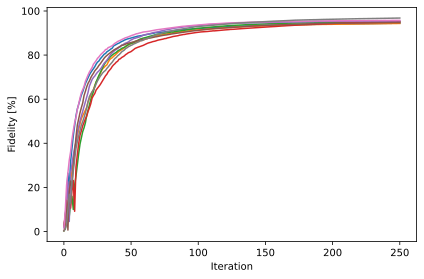

In [144]:
for i, opt_res in enumerate(ctrl_result.cost_history.iteration_values):
    plt.plot(1e2*(1-np.array(opt_res))) #, label=f'Trial {i}')
plt.xlabel('Iteration')
plt.ylabel('Fidelity [%]')
# plt.ylim(0, 100)
# plt.legend()
plt.tight_layout()
plt.show()

Convert controls dictionary into np arrays

In [102]:
# controls = dict()
# for q in range(len(qram.cutoffs)):
#     name = f'$\gamma_{q}$'
#     controls.update({name:result.output[name]})
# plot_controls(plt.figure(), controls, unit_symbol='GHz', polar=False)

Plot pi pulse qubit controls

Fidelity: 0.9679242879679109


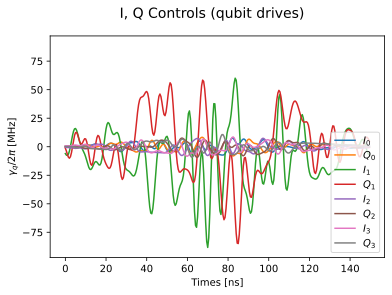

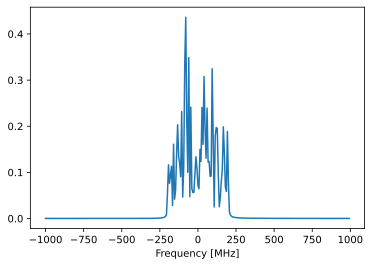

In [147]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times = []
I_values = [None]*4
Q_values = [None]*4
control_qubits = []
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            # if q==1 and j==0: times.append(t)
            if q==1 and j==0: times.append(t)
            t += pulse['duration']
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
    I_values[q] = np.array(I_values_q)
    Q_values[q] = np.array(Q_values_q)
    control_qubits.append(q)
times = np.array(times)

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 0
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # if q!=1: continue
    ymax_q = 1.1*max(abs(np.concatenate((I_values[q].flatten(), Q_values[q].flatten()))))
    ymax = max((ymax_q, ymax))
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
    plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
plt.ylim(-1e3*ymax, 1e3*ymax)
plt.ylabel(f'$\gamma_q/2\pi$ [MHz]')
plt.legend()
plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

fourier = np.fft.fftshift(np.abs(np.fft.fft(I_values[0] + 1j*Q_values[0])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(times[1]-times[0])))
plt.plot(1e3*freqs, fourier)
plt.xlabel('Frequency [MHz]')
# plt.xlim(-500, 500)
plt.show()


Plot sideband controls

In [326]:
# times_sb = []
# I_values_sb = []
# Q_values_sb = []
# qubits_sb = []
# for q in range(qram.nqubits):
#     if q == 1: continue
#     I_values_q = []
#     Q_values_q = []
#     t = 0
#     for j in range(2): # I, Q
#         name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
#         control = ctrl_result.output[name]
#         for step, pulse in enumerate(control):
#             if q==0 and j==0: times_sb.append(t)
#             t += pulse['duration']
#             # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
#             if j==0: I_values_q.append(pulse['value'])
#             else: Q_values_q.append(pulse['value'])
#     I_values_sb.append(I_values_q)
#     Q_values_sb.append(Q_values_q)
#     qubits_sb.append(q)

# times_sb = np.array(times_sb)
# I_values_sb = np.array(I_values_sb)
# Q_values_sb = np.array(Q_values_sb)
# qubits_sb = np.array(qubits_sb)

# I_values = I_values_sb
# Q_values = Q_values_sb
# times = times_sb
# plt.figure(figsize=(6,8))
# plt.suptitle('I, Q Controls (sideband drives)', fontsize=14)
# ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))
# for q in range(len(I_values)):
#     plt.subplot(int(f'41{q+1}'))
#     plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
#     plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
#     plt.ylim(-1e3*ymax, 1e3*ymax)
#     plt.ylabel(f'$\epsilon_{q}/2\pi$ [MHz]')
#     plt.legend()
# plt.xlabel('Times [ns]')
# plt.tight_layout()
# plt.show()

Plotting qctrl state evolution from different initial states

In [327]:
psi0 = 'e(g+ie)gg'
state_result = ctrl_result.output[psi0]['value']
ref_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(qt.Qobj(state_result[t])))**2 for t in range(len(sample_times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(sample_times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(sample_times, [0.5]*len(sample_times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

KeyError: 'e(g+ie)gg'

In [403]:
gate_durations = np.linspace(25, 250, 10)
print(gate_durations) 
sinc_cutoffs_lin_MHz = np.linspace(25, 250, 10)
print(sinc_cutoffs_lin_MHz)

results = []
for gate_duration in gate_durations:
    sample_times = np.linspace(0, gate_duration, num_segments_q)
    for sinc_cutoff_lin_MHz in sinc_cutoffs_lin_MHz:
        sinc_cutoff_q = sinc_cutoff_lin_MHz*2*np.pi*1e-3
        ncycles = int(np.ceil(sinc_cutoff_q*gate_duration/2/np.pi)) # per gate duration for frequency cutoff for drive
        num_opt_vars_q = 2*ncycles
        num_segments_q = ncycles*10
        num_segments_q = min(num_segments_q, int(gate_duration / 0.1565)) # hardware maximum: 1 sample every 0.1565 ns

        graph = qctrl.create_graph()
        H_tot, output_node_names = setup_graph(graph=graph, initial_values=initial_values, unitary_cost=unitary_cost)
        output_node_names = setup_cost_unitary(
            graph=graph,
            target_operator=computational_target_operator,
            H_tot=H_tot,
            output_node_names=output_node_names,
            sample_times=sample_times,
        )

        start_time = time.time()
        result = qctrl.functions.calculate_optimization(
            graph=graph,
            cost_node_name='cost',
            output_node_names=output_node_names,
            optimization_count=8,
            target_cost=1e-3,
            max_iteration_count=150,
            # max_iteration_count=1,
            cost_history_scope='ALL',
        )
        print("Run time (s):", time.time() - start_time, flush=True)
        results.append(result)

[ 25.  50.  75. 100. 125. 150. 175. 200. 225. 250.]
[ 25.  50.  75. 100. 125. 150. 175. 200. 225. 250.]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765800") has started.
Your task calculate_optimization (action_id="1765800") has completed.
Run time (s): 5.090827941894531


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765801") has started.
Your task calculate_optimization (action_id="1765801") has completed.
Run time (s): 5.005343914031982


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765802") has started.
Your task calculate_optimization (action_id="1765802") has completed.
Run time (s): 5.035808801651001


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765803") has started.
Your task calculate_optimization (action_id="1765803") has completed.
Run time (s): 5.035184621810913


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765804") has started.
Your task calculate_optimization (action_id="1765804") has completed.
Run time (s): 5.018772840499878


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765805") has started.
Your task calculate_optimization (action_id="1765805") has completed.
Run time (s): 4.977400302886963


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765806") has started.
Your task calculate_optimization (action_id="1765806") has completed.
Run time (s): 7.267857313156128


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765807") has started.
Your task calculate_optimization (action_id="1765807") has completed.
Run time (s): 7.1964709758758545


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765808") has started.
Your task calculate_optimization (action_id="1765808") has completed.
Run time (s): 7.195802450180054


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765809") has started.
Your task calculate_optimization (action_id="1765809") has completed.
Run time (s): 7.1113121509552


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765812") has started.
Your task calculate_optimization (action_id="1765812") has completed.
Run time (s): 5.284925937652588


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765815") has started.
Your task calculate_optimization (action_id="1765815") has completed.
Run time (s): 7.575836181640625


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765816") has started.
Your task calculate_optimization (action_id="1765816") has completed.
Run time (s): 7.504748344421387


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765817") has started.
Your task calculate_optimization (action_id="1765817") has completed.
Run time (s): 9.728089332580566


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765818") has started.
Your task calculate_optimization (action_id="1765818") has completed.
Run time (s): 9.780102968215942


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765819") has started.
Your task calculate_optimization (action_id="1765819") has completed.
Run time (s): 9.751861095428467


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765820") has started.
Your task calculate_optimization (action_id="1765820") has completed.
Run time (s): 9.966955184936523


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765823") has started.
Your task calculate_optimization (action_id="1765823") has completed.
Run time (s): 11.965826511383057


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765824") has started.
Your task calculate_optimization (action_id="1765824") has completed.
Run time (s): 14.238448143005371


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765825") has started.
Your task calculate_optimization (action_id="1765825") has completed.
Run time (s): 14.173915386199951


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765826") has started.
Your task calculate_optimization (action_id="1765826") has completed.
Run time (s): 7.9231719970703125


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765829") has started.
Your task calculate_optimization (action_id="1765829") has completed.
Run time (s): 7.886370420455933


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765830") has started.
Your task calculate_optimization (action_id="1765830") has completed.
Run time (s): 10.262599229812622


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765831") has started.
Your task calculate_optimization (action_id="1765831") has completed.
Run time (s): 12.303298234939575


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765832") has started.
Your task calculate_optimization (action_id="1765832") has completed.
Run time (s): 12.319900035858154


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765835") has started.
Your task calculate_optimization (action_id="1765835") has completed.
Run time (s): 14.434547662734985


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765836") has started.
Your task calculate_optimization (action_id="1765836") has completed.
Run time (s): 16.944961547851562


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765837") has started.
Your task calculate_optimization (action_id="1765837") has completed.
Run time (s): 16.678240060806274


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765838") has started.
Your task calculate_optimization (action_id="1765838") has completed.
Run time (s): 18.806255340576172


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765839") has started.
Your task calculate_optimization (action_id="1765839") has completed.
Run time (s): 18.96322512626648


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765840") has started.
Your task calculate_optimization (action_id="1765840") has completed.
Run time (s): 8.335488080978394


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765841") has started.
Your task calculate_optimization (action_id="1765841") has completed.
Run time (s): 10.434094429016113


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765842") has started.
Your task calculate_optimization (action_id="1765842") has completed.
Run time (s): 12.395252227783203


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765843") has started.
Your task calculate_optimization (action_id="1765843") has completed.
Run time (s): 14.872512578964233


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765844") is currently in a queue waiting to be processed.
Your task calculate_optimization (action_id="1765844") has started.
Your task calculate_optimization (action_id="1765844") has completed.
Run time (s): 21.37806248664856


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765846") has started.
Your task calculate_optimization (action_id="1765846") has completed.
Run time (s): 19.150254011154175


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765847") has started.
Your task calculate_optimization (action_id="1765847") has completed.
Run time (s): 21.174738883972168


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765848") has started.
Your task calculate_optimization (action_id="1765848") has completed.
Run time (s): 26.016883373260498


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765849") has started.
Your task calculate_optimization (action_id="1765849") has completed.
Run time (s): 23.433176279067993


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765850") has started.
Your task calculate_optimization (action_id="1765850") has completed.
Run time (s): 25.61540460586548


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765851") has started.
Your task calculate_optimization (action_id="1765851") has completed.
Run time (s): 10.887575149536133


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765852") has started.
Your task calculate_optimization (action_id="1765852") has completed.
Run time (s): 12.86992335319519


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765853") has started.
Your task calculate_optimization (action_id="1765853") has completed.
Run time (s): 17.31295108795166


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765855") has started.
Your task calculate_optimization (action_id="1765855") has completed.
Run time (s): 17.298321962356567


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765856") has started.
Your task calculate_optimization (action_id="1765856") has completed.
Run time (s): 19.421074151992798


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765857") has started.
Your task calculate_optimization (action_id="1765857") has completed.
Run time (s): 21.65021800994873


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765859") has started.
Your task calculate_optimization (action_id="1765859") has completed.
Run time (s): 24.066895484924316


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765860") has started.
Your task calculate_optimization (action_id="1765860") has completed.
Run time (s): 25.845279216766357


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765862") has started.
Your task calculate_optimization (action_id="1765862") has completed.
Run time (s): 28.367547273635864


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765863") has started.
Your task calculate_optimization (action_id="1765863") has completed.
Run time (s): 30.51571536064148


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765865") has started.
Your task calculate_optimization (action_id="1765865") has completed.
Run time (s): 10.789567232131958


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765867") has started.
Your task calculate_optimization (action_id="1765867") has completed.
Run time (s): 15.232163429260254


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765868") has started.
Your task calculate_optimization (action_id="1765868") has completed.
Run time (s): 17.126144886016846


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765870") has started.
Your task calculate_optimization (action_id="1765870") has completed.
Run time (s): 19.337524890899658


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765872") has started.
Your task calculate_optimization (action_id="1765872") has completed.
Run time (s): 24.18716335296631


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765873") has started.
Your task calculate_optimization (action_id="1765873") has completed.
Run time (s): 24.235522270202637


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765874") has started.
Your task calculate_optimization (action_id="1765874") has completed.
Run time (s): 28.343089818954468


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765876") has started.
Your task calculate_optimization (action_id="1765876") has completed.
Run time (s): 31.00739622116089


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765877") has started.
Your task calculate_optimization (action_id="1765877") has completed.
Run time (s): 33.01119613647461


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765878") has started.
Your task calculate_optimization (action_id="1765878") has completed.
Run time (s): 35.44658350944519


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765879") has started.
Your task calculate_optimization (action_id="1765879") has completed.
Run time (s): 13.0227689743042


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765880") has started.
Your task calculate_optimization (action_id="1765880") has completed.
Run time (s): 13.269788980484009


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765881") has started.
Your task calculate_optimization (action_id="1765881") has completed.
Run time (s): 15.329522609710693


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765882") has started.
Your task calculate_optimization (action_id="1765882") has completed.
Run time (s): 17.73546266555786


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765883") has started.
Your task calculate_optimization (action_id="1765883") has completed.
Run time (s): 19.603596687316895


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765884") has started.
Your task calculate_optimization (action_id="1765884") has completed.
Run time (s): 22.287286520004272


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765885") has started.
Your task calculate_optimization (action_id="1765885") has completed.
Run time (s): 24.6694118976593


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765886") has started.
Your task calculate_optimization (action_id="1765886") has completed.
Run time (s): 26.84098219871521


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765887") has started.
Your task calculate_optimization (action_id="1765887") has completed.
Run time (s): 28.940563678741455


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765888") has started.
Your task calculate_optimization (action_id="1765888") has completed.
Run time (s): 30.705459356307983


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765889") has started.
Your task calculate_optimization (action_id="1765889") has completed.
Run time (s): 10.738270044326782


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765890") has started.
Your task calculate_optimization (action_id="1765890") has completed.
Run time (s): 15.599180221557617


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765891") has started.
Your task calculate_optimization (action_id="1765891") has completed.
Run time (s): 18.198259592056274


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765892") has started.
Your task calculate_optimization (action_id="1765892") has completed.
Run time (s): 19.721312999725342


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765893") has started.
Your task calculate_optimization (action_id="1765893") has completed.
Run time (s): 22.202728509902954


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765894") has started.
Your task calculate_optimization (action_id="1765894") has completed.
Run time (s): 24.435149669647217


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765895") has started.
Your task calculate_optimization (action_id="1765895") has completed.
Run time (s): 26.932429552078247


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765896") has started.
Your task calculate_optimization (action_id="1765896") has completed.
Run time (s): 28.688503980636597


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765897") has started.
Your task calculate_optimization (action_id="1765897") has completed.
Run time (s): 31.551991939544678


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765898") has started.
Your task calculate_optimization (action_id="1765898") has completed.
Run time (s): 33.61874437332153


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765899") has started.
Your task calculate_optimization (action_id="1765899") has completed.
Run time (s): 13.810201406478882


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765900") has started.
Your task calculate_optimization (action_id="1765900") has completed.
Run time (s): 16.11642026901245


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765901") has started.
Your task calculate_optimization (action_id="1765901") has completed.
Run time (s): 18.233580112457275


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765902") has started.
Your task calculate_optimization (action_id="1765902") has completed.
Run time (s): 20.512128829956055


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765903") has started.
Your task calculate_optimization (action_id="1765903") has completed.
Run time (s): 25.73815107345581


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765904") has started.
Your task calculate_optimization (action_id="1765904") has completed.
Run time (s): 27.5368971824646


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765905") has started.
Your task calculate_optimization (action_id="1765905") has completed.
Run time (s): 29.654412508010864


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765906") has started.
Your task calculate_optimization (action_id="1765906") has completed.
Run time (s): 31.10514736175537


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765907") has started.
Your task calculate_optimization (action_id="1765907") has completed.
Run time (s): 33.864288330078125


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765908") has started.
Your task calculate_optimization (action_id="1765908") has completed.
Run time (s): 38.78616905212402


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765909") has started.
Your task calculate_optimization (action_id="1765909") has completed.
Run time (s): 14.06825566291809


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765910") has started.
Your task calculate_optimization (action_id="1765910") has completed.
Run time (s): 19.32398533821106


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765911") has started.
Your task calculate_optimization (action_id="1765911") has completed.
Run time (s): 20.265923500061035


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765912") has started.
Your task calculate_optimization (action_id="1765912") has completed.
Run time (s): 22.96408724784851


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765913") has started.
Your task calculate_optimization (action_id="1765913") has completed.
Run time (s): 27.665855884552002


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765914") has started.
Your task calculate_optimization (action_id="1765914") has completed.
Run time (s): 29.01145839691162


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765915") has started.
Your task calculate_optimization (action_id="1765915") has completed.
Run time (s): 32.21928095817566


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765916") has started.
Your task calculate_optimization (action_id="1765916") has completed.
Run time (s): 36.68352246284485


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765917") has started.
Your task calculate_optimization (action_id="1765917") has completed.
Run time (s): 38.76072669029236


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1765918") has started.
Your task calculate_optimization (action_id="1765918") has completed.
Run time (s): 43.62517213821411


97.77531893078208
best gate duration (ns) 250.0
best sinc cutoff (MHz) 250.0


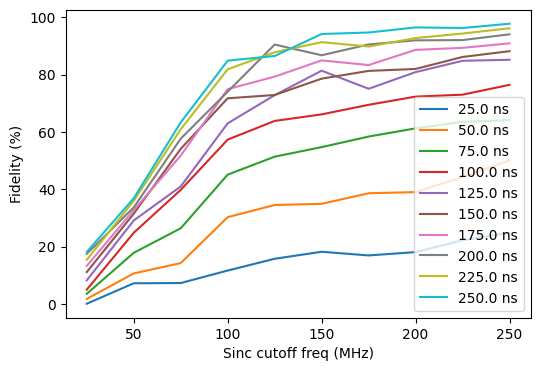

In [429]:
# %matplotlib widget
%matplotlib inline

fidelities = []
for result in results:
    fidelities.append(1-result.output["cost"]["value"])
fidelities = np.array(fidelities)
print(100*max(fidelities))
best_fid = max(fidelities)

fidelities = fidelities.reshape(len(gate_durations), len(sinc_cutoffs_lin_MHz))
i_best_fid = np.argwhere(fidelities==best_fid)
print('best gate duration (ns)', gate_durations[i_best_fid[0, 0]])
print('best sinc cutoff (MHz)', sinc_cutoffs_lin_MHz[i_best_fid[0, 1]])

for i, gate_duration in enumerate(gate_durations):
    plt.plot(sinc_cutoffs_lin_MHz, 100*fidelities[i, :], label=f'{gate_duration} ns')
plt.legend()
plt.xlabel('Sinc cutoff freq (MHz)')
plt.ylabel('Fidelity (%)')
plt.show()